# Learn graph from piecewise constant signals

In [1]:
from scipy import spatial
from sklearn import metrics
import utils
import numpy as np
import networkx as nx
import learn_graph as lg
import matplotlib.pyplot as plt
%matplotlib inline

## Generate ground truth graph

In [2]:
N = 256 # Number of nodes
Ne = int(N * (N - 1) / 2) # Number of edges
Nc = 8 # Number of communities
p = 0.5 # Probability of intra-community connection
q = 0.07 # Probability of inter-community connection

In [3]:
# Create a community graph
Base = np.kron( np.eye(Nc), np.ones((int(N/Nc), int(N/Nc))) )
Comm_conn = np.random.binomial(n=1, p=p, size=(N,N))
World_conn = np.random.binomial(n=1, p=q, size=(N,N))

# Ground truth weighted adjacency matrix
W_gt = np.logical_or(np.logical_and(Base, Comm_conn), World_conn)
W_gt[:] = np.logical_and(W_gt, W_gt.T)
W_gt = W_gt.astype(float)
W_gt[:] = W_gt - np.diag(np.diag(W_gt))

# Ground truth graph
G_gt = nx.from_numpy_matrix(W_gt)

# Coordinates of the communities
comm = np.array(list(zip(np.cos(2 * np.pi * np.arange(1, Nc + 1) / Nc),
                         np.sin(2 * np.pi * np.arange(1, Nc + 1) / Nc))))
comm *= np.sqrt(N)

# Coordinates of the nodes within the communities
pts = np.random.rand(N, 2)
pts = np.array([[elem[0] * np.cos(2 * np.pi * elem[1]), 
                 elem[0] * np.sin(2 * np.pi * elem[1])] for elem in pts])

# Global positions
pos = []
rad = np.sqrt(N/Nc)
for j in np.arange(Nc):
    for i in np.arange(int(N/Nc)):
        pos.append(comm[j,:] + rad * pts[i * (j + 1),:])

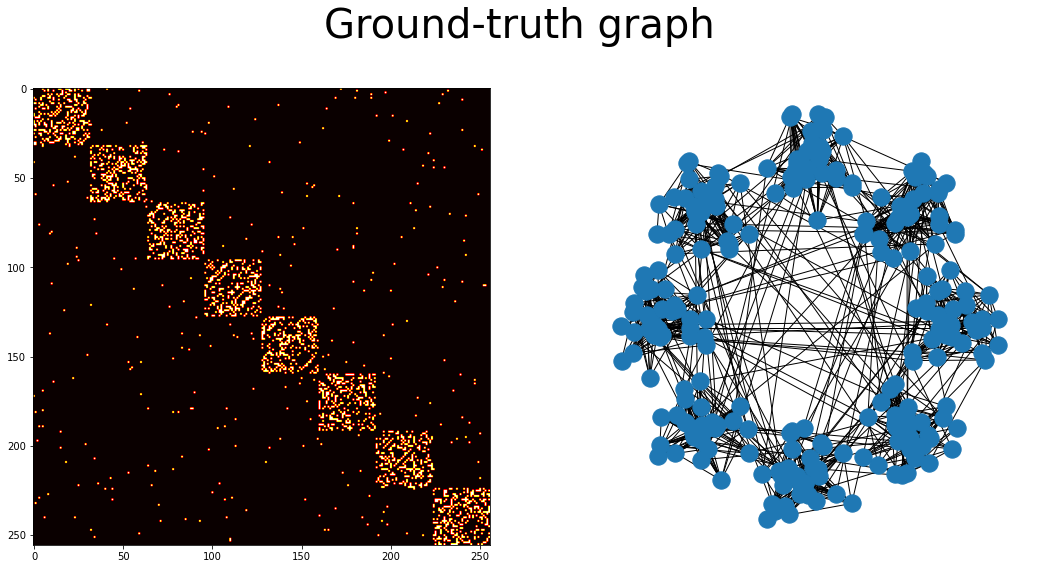

In [4]:
# Display graph
plt.figure(figsize=(18, 9))
plt.suptitle('Ground-truth graph', fontsize=40)

plt.subplot(1,2,1)
plt.imshow(W_gt, cmap='hot')

plt.subplot(1,2,2)
nx.draw(G_gt, pos=pos)

## Check spectrum of ground-truth graph Laplacian

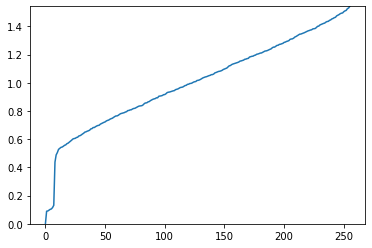

In [5]:
L_gt = utils.create_laplacian(W_gt, lap_type='normalized', 
                              sparse_flag=False)
e_gt, U_gt = np.linalg.eigh(L_gt)
idx = sorted(range(len(e_gt)), key=lambda k: e_gt[k])
e_gt[:] = e_gt[idx]
U_gt[:] = U_gt[:,idx]
plt.plot(e_gt)
plt.ylim([0,max(e_gt)])
plt.show()

## Generate samples

In [6]:
# Low-pass filter random signals
N_samples = 32
R = np.random.multivariate_normal(mean=np.zeros((N,)), cov=np.eye(N),
                                  size=N_samples).T
X = U_gt[:,0:Nc+1] @ (U_gt[:,0:Nc+1].T @ R)

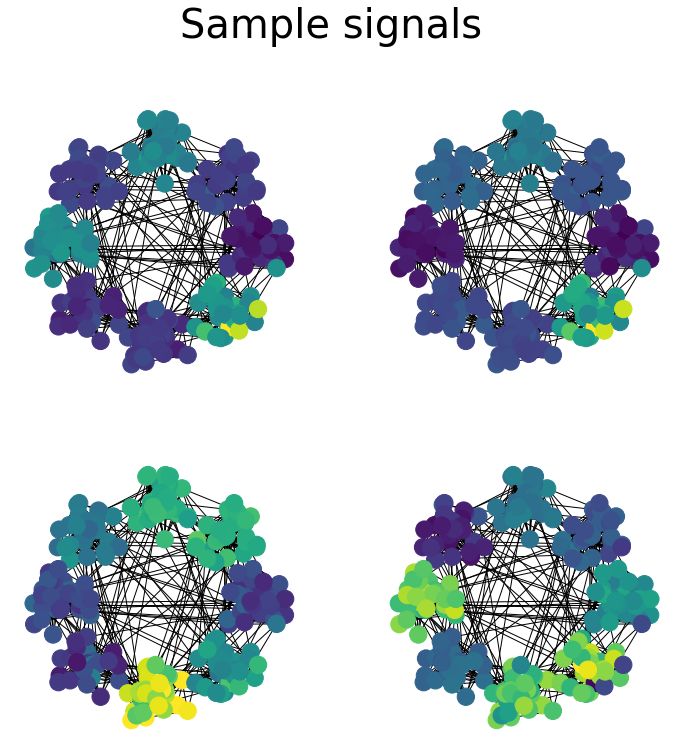

In [7]:
# Display samples
plt.figure(figsize=(12, 12))
plt.suptitle('Sample signals', fontsize=40)

plt.subplot(2,2,1)
nx.draw(G_gt, pos=pos, node_color=X[:,0])

plt.subplot(2,2,2)
nx.draw(G_gt, pos=pos, node_color=X[:,1])

plt.subplot(2,2,3)
nx.draw(G_gt, pos=pos, node_color=X[:,2])

plt.subplot(2,2,4)
nx.draw(G_gt, pos=pos, node_color=X[:,3])

## Solve the optimization problem

In [8]:
# Solve the problem
W, problem = lg.log_degree_barrier(X, dist_type='cityblock', alpha=1, beta=1.15, step=0.5, w0=None,
                                   maxit=1000, rtol=1e-5, retall=True, verbosity='LOW')

Solution found after 226 iterations:
    objective function f(sol) = 2.071515e+02
    stopping criterion: RTOL


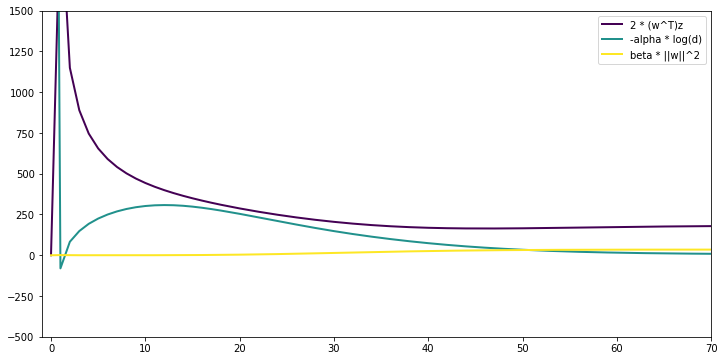

In [9]:
# Display objective values
fig, ax = utils.plot_objectives(problem['objective'], 
                                labels=['2 * (w^T)z', 
                                        '-alpha * log(d)',
                                        'beta * ||w||^2'])
ax.set_xlim([-1, 70])
ax.set_ylim([-500, 1500])
plt.show()

## Recover learned graph

In [10]:
W_thresh = np.max(W_gt) * W / np.max(W)
W_thresh[W_thresh < 0.1] = 0
G_learned = nx.from_numpy_matrix(W_thresh)

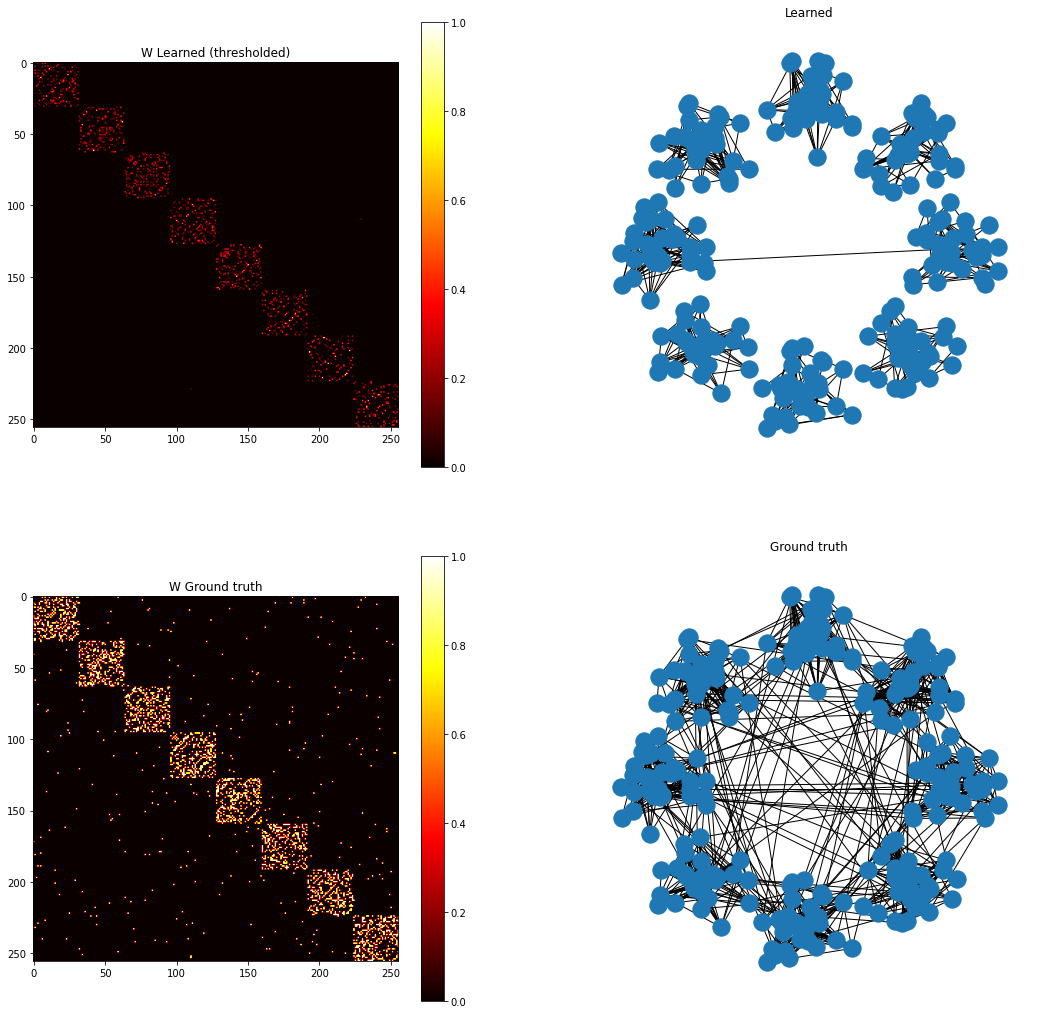

In [11]:
plt.figure(figsize=(18, 18))
plt.subplot(2,2,1)
plt.imshow(W_thresh, cmap='hot')
plt.colorbar()
plt.title('W Learned (thresholded)')

plt.subplot(2,2,2)
nx.draw(G_learned, pos=pos)
plt.title('Learned')

plt.subplot(2,2,3)
plt.imshow(W_gt, cmap='hot')
plt.colorbar()
plt.title('W Ground truth')

plt.subplot(2,2,4)
nx.draw(G_gt, pos=pos)
plt.title('Ground truth')

plt.show()

In [12]:
f_score = metrics.f1_score((spatial.distance.squareform(W_gt) > 0), 
                           (spatial.distance.squareform(W_thresh) > 0))
print("F-score = {:.2f}".format(f_score))

F-score = 0.30


## Compare spectra of the Laplacian matrices

In [13]:
L = utils.create_laplacian(W, lap_type='normalized', 
                           sparse_flag=False)
e, _ = np.linalg.eigh(L)
e = np.sort(e)

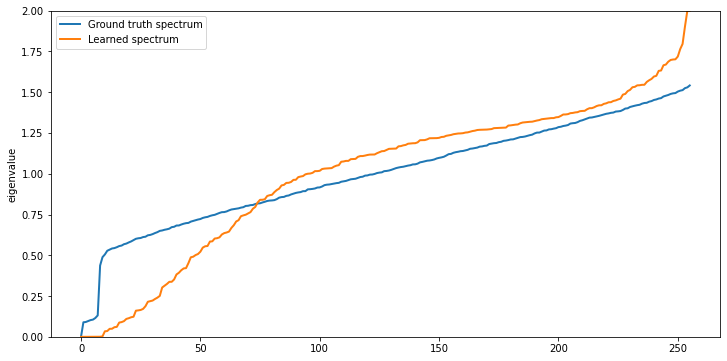

In [14]:
plt.figure(figsize=(12, 6))

plt.plot(e_gt, linewidth=2)
plt.plot(e, linewidth=2)
plt.ylabel('eigenvalue')
plt.ylim([0,max(np.max(e_gt), np.max(e))])
plt.legend(['Ground truth spectrum', 'Learned spectrum'], loc='best')

plt.show()